In [ ]:
%pip install rdkit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.2/34.2 MB 43.4 MB/s eta 0:00:00


Étape 1 : Modèle PGM
PGM - R^2: 0.83, MSE: 0.29, Accuracy: 0.70


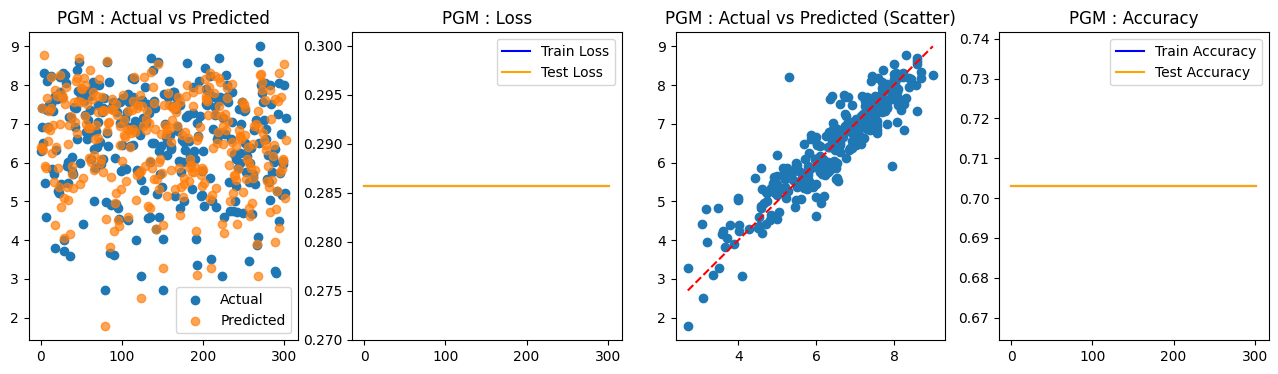

Étape 2 : Modèle GNN
Epoch 100/500, Loss: 0.5274, Accuracy: 0.5570
Epoch 200/500, Loss: 0.2064, Accuracy: 0.7785
Epoch 300/500, Loss: 0.1147, Accuracy: 0.8802
Epoch 400/500, Loss: 0.0782, Accuracy: 0.9306
Epoch 500/500, Loss: 0.0595, Accuracy: 0.9587
GNN - R^2: 0.83, MSE: 0.29, Accuracy: 0.78


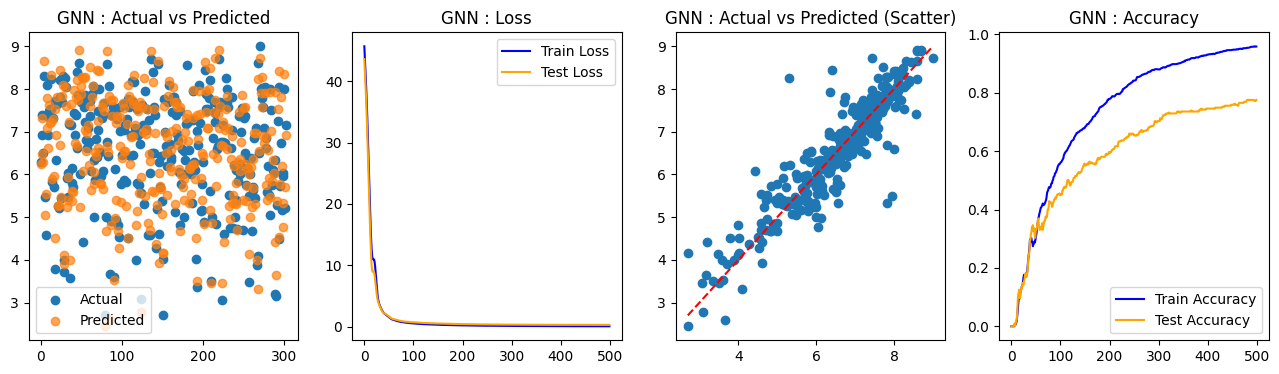

Étape 3 : Modèle PGM + GNN
Epoch 100/500, Combined Loss: 0.3989, Accuracy: 0.6256
Epoch 200/500, Combined Loss: 0.1685, Accuracy: 0.8207
Epoch 300/500, Combined Loss: 0.1011, Accuracy: 0.9000
Epoch 400/500, Combined Loss: 0.0688, Accuracy: 0.9413
Epoch 500/500, Combined Loss: 0.0509, Accuracy: 0.9636
PGM+GNN - R^2: 0.84, MSE: 0.27, Accuracy: 0.79


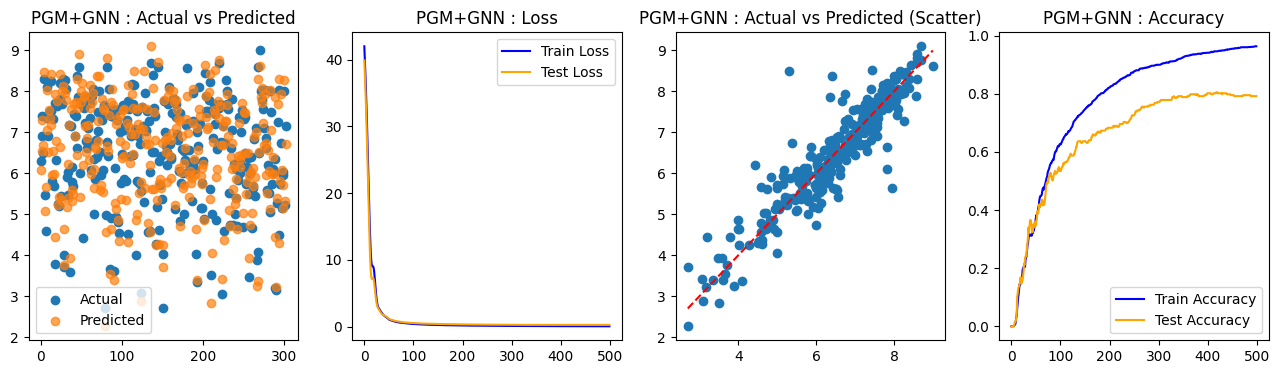

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Load BACE data
data = pd.read_csv('bace.csv')  # Replace with the actual path to your CSV file
data.columns = data.columns.str.strip()  # Clean any spaces in column names

# Data preprocessing
X = data.drop(columns=['pIC50', 'CID', 'mol', 'Class', 'Model'], errors='ignore')  # Adjust columns according to your data
y = data['pIC50']

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Set accuracy threshold for regression
accuracy_threshold = 0.5

# Function to plot performance
def plot_results(model_name, y_test, preds, train_losses, test_losses, train_accuracies, test_accuracies, title_suffix=""):
    plt.figure(figsize=(16, 4))

    # Actual vs Predicted
    plt.subplot(1, 4, 1)
    plt.scatter(range(len(y_test)), y_test, label="Actual")
    plt.scatter(range(len(y_test)), preds, label="Predicted", alpha=0.7)
    plt.title(f"{model_name} {title_suffix}: Actual vs Predicted")
    plt.legend()

    # Loss Graph (train vs test)
    plt.subplot(1, 4, 2)
    plt.plot(train_losses, label="Train Loss", color='blue')
    plt.plot(test_losses, label="Test Loss", color='orange')
    plt.title(f"{model_name} {title_suffix}: Loss")
    plt.legend()

    # Actual vs Predicted Scatter
    plt.subplot(1, 4, 3)
    plt.scatter(y_test, preds)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.title(f"{model_name} {title_suffix}: Actual vs Predicted (Scatter)")

    # Accuracy Graph (train vs test)
    plt.subplot(1, 4, 4)
    plt.plot(train_accuracies, label="Train Accuracy", color='blue')
    plt.plot(test_accuracies, label="Test Accuracy", color='orange')
    plt.title(f"{model_name} {title_suffix}: Accuracy")
    plt.legend()

    plt.show()

### Step 1: PGM Model ###
print("Step 1: PGM Model")
pgm_model = BayesianRidge()
pgm_model.fit(X_train, y_train)
pgm_preds = pgm_model.predict(X_test)

# Evaluate PGM model performance
pgm_r2 = r2_score(y_test, pgm_preds)
pgm_mse = mean_squared_error(y_test, pgm_preds)
pgm_accuracy = np.mean(np.abs(pgm_preds - y_test) < accuracy_threshold)  # Accuracy based on a threshold
print(f"PGM - R^2: {pgm_r2:.2f}, MSE: {pgm_mse:.2f}, Accuracy: {pgm_accuracy:.2f}")

# Plot results for PGM
plot_results("PGM", y_test, pgm_preds, [pgm_mse] * len(y_test), [pgm_mse] * len(y_test), [pgm_accuracy] * len(y_test), [pgm_accuracy] * len(y_test))

### Step 2: GNN Model ###
print("Step 2: GNN Model")

# Define the GNN model
class GNN(nn.Module):
    def __init__(self, input_dim):
        super(GNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Convert data to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Initialize the GNN model
gnn_model = GNN(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001)

# Train the GNN model
epochs = 500
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    gnn_model.train()
    optimizer.zero_grad()
    predictions = gnn_model(X_train_t)
    loss = criterion(predictions, y_train_t)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Calculate accuracy during training
    train_accuracy = np.mean(np.abs(predictions.detach().numpy().flatten() - y_train_t.numpy().flatten()) < accuracy_threshold)
    train_accuracies.append(train_accuracy)

    # Calculate accuracy and loss on the test dataset
    gnn_model.eval()
    with torch.no_grad():
        test_preds = gnn_model(X_test_t)
        test_loss = criterion(test_preds, y_test_t)
        test_accuracy = np.mean(np.abs(test_preds.detach().numpy().flatten() - y_test_t.numpy().flatten()) < accuracy_threshold)

    test_losses.append(test_loss.item())
    test_accuracies.append(test_accuracy)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}")

# Evaluate the GNN model
gnn_model.eval()
gnn_preds = gnn_model(X_test_t).detach().numpy().flatten()
gnn_r2 = r2_score(y_test, gnn_preds)
gnn_mse = mean_squared_error(y_test, gnn_preds)
gnn_accuracy = np.mean(np.abs(gnn_preds - y_test) < accuracy_threshold)
print(f"GNN - R^2: {gnn_r2:.2f}, MSE: {gnn_mse:.2f}, Accuracy: {gnn_accuracy:.2f}")

# Plot results for GNN
plot_results("GNN", y_test, gnn_preds, train_losses, test_losses, train_accuracies, test_accuracies)

### Step 3: PGM+GNN Model (Combination) ###
print("Step 3: PGM + GNN Model")

# Use the PGM model predictions as additional input features for the GNN
pgm_preds_train = pgm_model.predict(X_train)
pgm_preds_test = pgm_model.predict(X_test)

# Add PGM predictions as a new feature
X_train_combined = np.column_stack([X_train, pgm_preds_train])
X_test_combined = np.column_stack([X_test, pgm_preds_test])

# Convert to PyTorch tensors
X_train_combined_t = torch.tensor(X_train_combined, dtype=torch.float32)
X_test_combined_t = torch.tensor(X_test_combined, dtype=torch.float32)

# Define a combined GNN model
gnn_combined_model = GNN(input_dim=X_train_combined.shape[1])
optimizer = torch.optim.Adam(gnn_combined_model.parameters(), lr=0.001)

# Train the combined model
combined_train_losses = []
combined_test_losses = []
combined_train_accuracies = []
combined_test_accuracies = []

for epoch in range(epochs):
    gnn_combined_model.train()
    optimizer.zero_grad()
    predictions = gnn_combined_model(X_train_combined_t)
    loss = criterion(predictions, y_train_t)
    loss.backward()
    optimizer.step()
    combined_train_losses.append(loss.item())

    # Calculate accuracy during training
    train_accuracy = np.mean(np.abs(predictions.detach().numpy().flatten() - y_train_t.numpy().flatten()) < accuracy_threshold)
    combined_train_accuracies.append(train_accuracy)

    # Calculate accuracy and loss on the test dataset
    gnn_combined_model.eval()
    with torch.no_grad():
        test_preds = gnn_combined_model(X_test_combined_t)
        test_loss = criterion(test_preds, y_test_t)
        test_accuracy = np.mean(np.abs(test_preds.detach().numpy().flatten() - y_test_t.numpy().flatten()) < accuracy_threshold)

    combined_test_losses.append(test_loss.item())
    combined_test_accuracies.append(test_accuracy)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Combined Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}")

# Evaluate the combined model
gnn_combined_model.eval()
gnn_combined_preds = gnn_combined_model(X_test_combined_t).detach().numpy().flatten()
gnn_combined_r2 = r2_score(y_test, gnn_combined_preds)
gnn_combined_mse = mean_squared_error(y_test, gnn_combined_preds)
gnn_combined


Step 1: PGM Model
PGM - R^2: 0.72, MSE: 0.48, Accuracy: 0.65


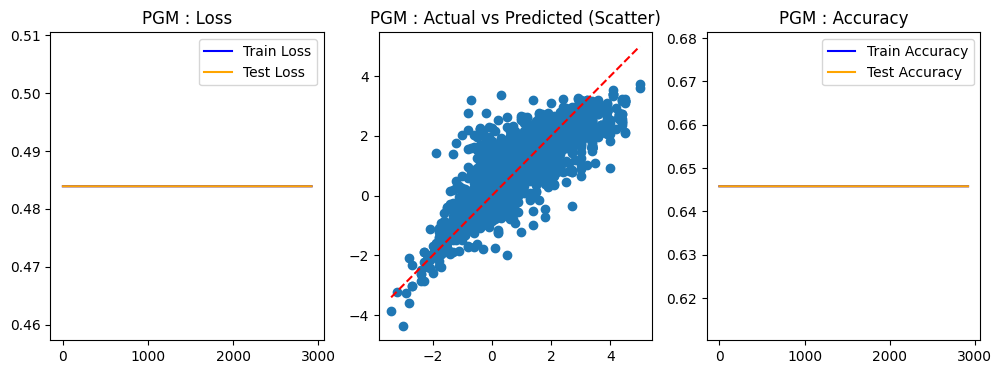

Step 2: GNN Model
Epoch 100/500, Loss: 0.3651, Accuracy: 0.7147
Epoch 200/500, Loss: 0.3321, Accuracy: 0.7310
Epoch 300/500, Loss: 0.3114, Accuracy: 0.7408
Epoch 400/500, Loss: 0.2978, Accuracy: 0.7512
Epoch 500/500, Loss: 0.2885, Accuracy: 0.7575
GNN - R^2: 0.82, MSE: 0.31, Accuracy: 0.75


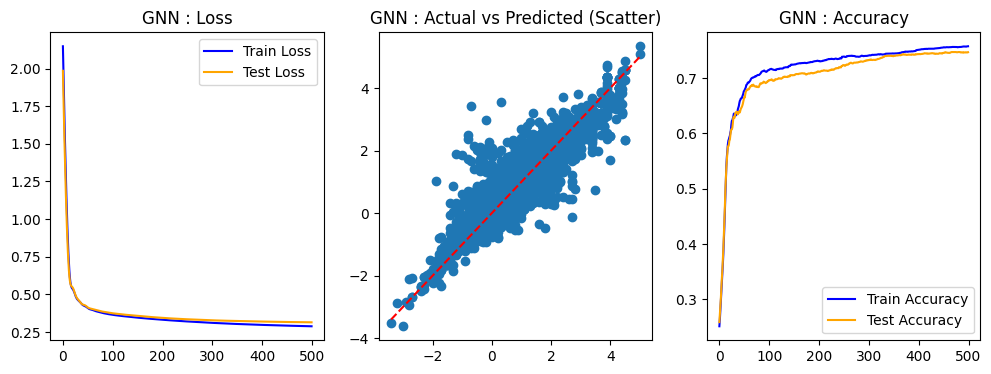

Step 3: PGM + GNN Model
Epoch 100/500, Loss: 0.3682, Accuracy: 0.7182
Epoch 200/500, Loss: 0.3310, Accuracy: 0.7343
Epoch 300/500, Loss: 0.3076, Accuracy: 0.7496
Epoch 400/500, Loss: 0.2937, Accuracy: 0.7545
Epoch 500/500, Loss: 0.2835, Accuracy: 0.7633
GNN Combined - R^2: 0.82, MSE: 0.31, Accuracy: 0.75


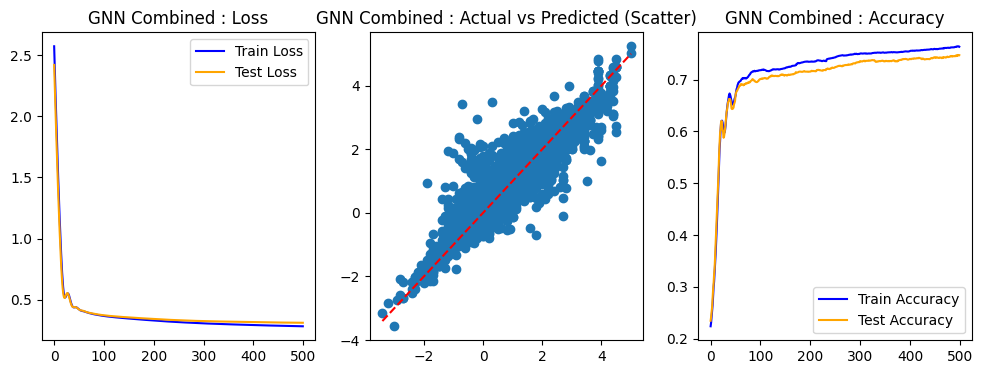

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import PandasTools

# Load the logp_synthetic data
data = pd.read_csv('logp_synthetic.csv', header=None, names=['SMILES', 'logP'])

# Function to compute molecular descriptors from SMILES
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(1)  # return a zero vector if SMILES is invalid
    descriptors = [
        Descriptors.MolWt(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.MolLogP(mol)  # LogP of the molecule
    ]
    return descriptors

# Apply descriptor computation to the SMILES column
X = np.array([compute_descriptors(smiles) for smiles in data['SMILES']])

# The target variable (logP)
y = data['logP'].values

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define an accuracy threshold for regression
accuracy_threshold = 0.5

# Function to plot results
def plot_results(model_name, y_test, preds, train_losses, test_losses, train_accuracies, test_accuracies, title_suffix=""):
    plt.figure(figsize=(12, 4))

    # Loss Graph (train vs test)
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Train Loss", color='blue')
    plt.plot(test_losses, label="Test Loss", color='orange')
    plt.title(f"{model_name} {title_suffix}: Loss")
    plt.legend()

    # Actual vs Predicted Scatter
    plt.subplot(1, 3, 2)
    plt.scatter(y_test, preds)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.title(f"{model_name} {title_suffix}: Actual vs Predicted (Scatter)")

    # Accuracy Graph (train vs test)
    plt.subplot(1, 3, 3)
    plt.plot(train_accuracies, label="Train Accuracy", color='blue')
    plt.plot(test_accuracies, label="Test Accuracy", color='orange')
    plt.title(f"{model_name} {title_suffix}: Accuracy")
    plt.legend()

    plt.show()

### Step 1: PGM Model ###
print("Step 1: PGM Model")
pgm_model = BayesianRidge()
pgm_model.fit(X_train, y_train)
pgm_preds = pgm_model.predict(X_test)

# Evaluate the performance of the PGM model
pgm_r2 = r2_score(y_test, pgm_preds)
pgm_mse = mean_squared_error(y_test, pgm_preds)
pgm_accuracy = np.mean(np.abs(pgm_preds - y_test) < accuracy_threshold)  # Accuracy based on a threshold
print(f"PGM - R^2: {pgm_r2:.2f}, MSE: {pgm_mse:.2f}, Accuracy: {pgm_accuracy:.2f}")

# Plot results for PGM
plot_results("PGM", y_test, pgm_preds, [pgm_mse] * len(y_test), [pgm_mse] * len(y_test), [pgm_accuracy] * len(y_test), [pgm_accuracy] * len(y_test))

### Step 2: GNN Model ###
print("Step 2: GNN Model")

# Define the GNN model
class GNN(nn.Module):
    def __init__(self, input_dim):
        super(GNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Convert data to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Initialize the GNN model
gnn_model = GNN(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001)

# Train the GNN model
epochs = 500
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    gnn_model.train()
    optimizer.zero_grad()
    predictions = gnn_model(X_train_t)
    loss = criterion(predictions, y_train_t)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Calculate accuracy during training
    train_accuracy = np.mean(np.abs(predictions.detach().numpy().flatten() - y_train_t.numpy().flatten()) < accuracy_threshold)
    train_accuracies.append(train_accuracy)

    # Calculate accuracy and loss on the test dataset
    gnn_model.eval()
    with torch.no_grad():
        test_preds = gnn_model(X_test_t)
        test_loss = criterion(test_preds, y_test_t)
        test_accuracy = np.mean(np.abs(test_preds.detach().numpy().flatten() - y_test_t.numpy().flatten()) < accuracy_threshold)

    test_losses.append(test_loss.item())
    test_accuracies.append(test_accuracy)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}")

# Evaluate the GNN model
gnn_model.eval()
gnn_preds = gnn_model(X_test_t).detach().numpy().flatten()
gnn_r2 = r2_score(y_test, gnn_preds)
gnn_mse = mean_squared_error(y_test, gnn_preds)
gnn_accuracy = np.mean(np.abs(gnn_preds - y_test) < accuracy_threshold)
print(f"GNN - R^2: {gnn_r2:.2f}, MSE: {gnn_mse:.2f}, Accuracy: {gnn_accuracy:.2f}")

# Plot results for GNN
plot_results("GNN", y_test, gnn_preds, train_losses, test_losses, train_accuracies, test_accuracies)

### Step 3: PGM+GNN Model (Combination) ###
print("Step 3: PGM + GNN Model")

# Use PGM model predictions as additional input features for the GNN
pgm_preds_train = pgm_model.predict(X_train)
pgm_preds_test = pgm_model.predict(X_test)

# Add PGM predictions as a new feature
X_train_combined = np.column_stack([X_train, pgm_preds_train])
X_test_combined = np.column_stack([X_test, pgm_preds_test])

# Convert to PyTorch tensors
X_train_combined_t = torch.tensor(X_train_combined, dtype=torch.float32)
X_test_combined_t = torch.tensor(X_test_combined, dtype=torch.float32)

# Define a combined GNN model
gnn_combined_model = GNN(input_dim=X_train_combined.shape[1])
optimizer = torch.optim.Adam(gnn_combined_model.parameters(), lr=0.001)

# Train the combined model
combined_train_losses = []
combined_test_losses = []
combined_train_accuracies = []
combined_test_accuracies = []

for epoch in range(epochs):
    gnn_combined_model.train()
    optimizer.zero_grad()
    predictions = gnn_combined_model(X_train_combined_t)
    loss = criterion(predictions, y_train_t)
    loss.backward()
    optimizer.step()
    combined_train_losses.append(loss.item())

    # Calculate accuracy during training
    train_accuracy = np.mean(np.abs(predictions.detach().numpy().flatten() - y_train_t.numpy().flatten()) < accuracy_threshold)
    combined_train_accuracies.append(train_accuracy)

    # Calculate accuracy and loss on the test dataset
    gnn_combined_model.eval()
    with torch.no_grad():
        test_preds = gnn_combined_model(X_test_combined_t)
        test_loss = criterion(test_preds, y_test_t)
        test_accuracy = np.mean(np.abs(test_preds.detach().numpy().flatten() - y_test_t.numpy().flatten()) < accuracy_threshold)

    combined_test_losses.append(test_loss.item())
    combined_test_accuracies.append(test_accuracy)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}")

# Evaluate the combined GNN model
gnn_combined_model.eval()
gnn_combined_preds = gnn_combined_model(X_test_combined_t).detach().numpy().flatten()
gnn_combined_r2 = r2_score(y_test, gnn_combined_preds)
gnn_combined_mse = mean_squared_error(y_test, gnn_combined_preds)
gnn_combined_accuracy = np.mean(np.abs(gnn_combined_preds - y_test) < accuracy_threshold)
print(f"GNN Combined - R^2: {gnn_combined_r2:.2f}, MSE: {gnn_combined_mse:.2f}, Accuracy: {gnn_combined_accuracy:.2f}")

# Plot results for combined model
plot_results("GNN Combined", y_test, gnn_combined_preds, combined_train_losses, combined_test_losses, combined_train_accuracies, combined_test_accuracies)
